In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pysal
import seaborn as sns
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from os.path import join
import os
from scipy import stats

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

from crime_patterns.final.plotting import plot_hotspots
from crime_patterns.analysis.point_patterns import evaluate_hotspots

%load_ext autoreload
%autoreload 2

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
data_dir = r"..\crime_patterns\data"
shapefiles_dir = os.path.join(data_dir, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_LSOA_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")


# crime_incidence_path = os.path.join(data_dir, r"uk_crime_data_all\2021-01\2021-01-city-of-london-street.csv")
crime_incidence_dir = os.path.join(data_dir, r"uk_crime_data_2019", "2019-12") #\2021-01\2021-01-city-of-london-street.csv")
mps_lsoa_crime_path = os.path.join(data_dir, r"MPS_LSOA_Level_Crime\MPS LSOA Level Crime (Historical).csv")
cleaned_data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"
london_greater_area_shp_path = os.path.join(cleaned_data_dir,  "Greater_London_Area.shp")

In [3]:
# os.path.isfile(london_greater_area_shp_path)

In [4]:
london_lsoa = gpd.read_file(london_LSOA_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)
london_greater_area = gpd.read_file(london_greater_area_shp_path)

In [5]:
data_dir = r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\data"

In [6]:
# db_gdf = gpd.read_file(join(data_dir, r"city-of-london-burglaries-2019-cleaned.shp"))
db = pd.read_csv(join(data_dir, r"city-of-london-burglaries-2019-cleaned.csv"))

In [8]:
X_coords, Y_coords, densities = evaluate_hotspots(longitudes=db["Longitude"], latitudes=db["Latitude"], region=london_greater_area)

(<Figure size 800x600 with 2 Axes>, <Axes: >)

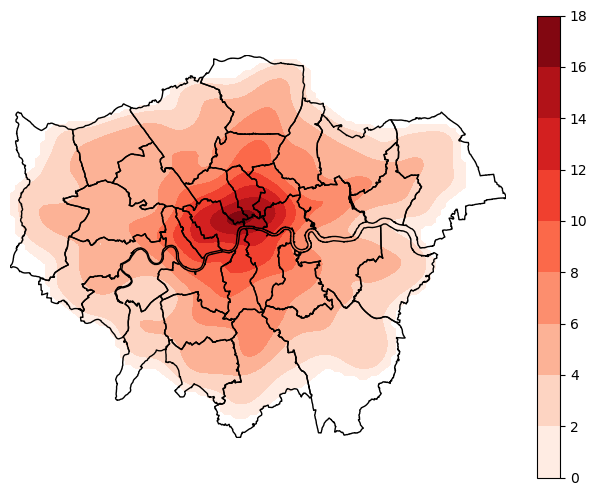

In [9]:
plot_hotspots(X_coords, Y_coords, densities, london_borough)

(-0.5525760651951521,
 0.37626392779633233,
 51.266502733936306,
 51.71213288478268)

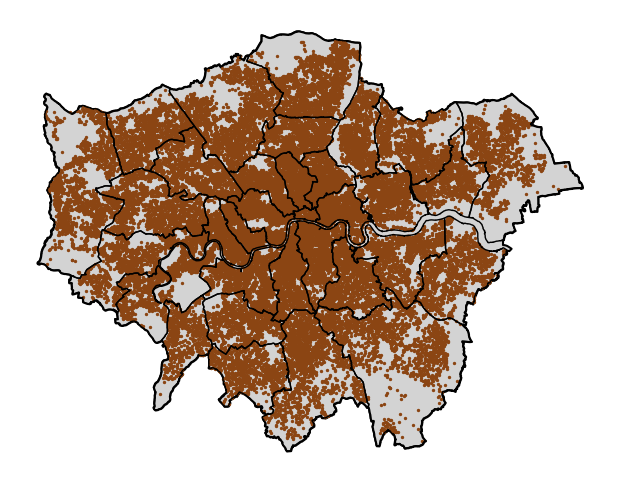

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

london_greater_area.to_crs("EPSG:4326").plot(ax=ax, fc="lightgray", alpha=1, ec="k", linewidth=1.5)
ax.scatter(db["Longitude"], db["Latitude"], s=2, c='saddlebrown')
london_borough.to_crs("EPSG:4326").plot(ax=ax, fc="None", alpha=1, ec="k", linewidth=1)

# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
plt.axis(False)

In [7]:

from sklearn.cluster import DBSCAN

def dbscan_cluster(latitudes,longitudes,epsilon,min_samples,**kwargs):
    '''
    Function to perform DBSCAN clustering for given parameters.
    
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine',
        **kwargs
    )
    
    # fit the algorithm
    dbscan.fit(
        np.radians(
            [x for x in zip(latitudes,longitudes)]
        )
    )
    
    # return the cluster labels
    return dbscan.labels_

In [70]:
labels = dbscan_cluster(
                        latitudes=db["Latitude"],
                        longitudes=db["Longitude"],
                        epsilon=1.5, # km
                        min_samples=330,
                        )

In [71]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 23487


In [72]:
# # Define DBSCAN
# clusterer = DBSCAN()
# # Fit to our data
# clusterer.fit(db[["Longitude", "Latitude"]])

In [73]:
# lbls = pd.Series(clusterer.labels_, index=db.index)

In [74]:
labels = pd.Series(labels, index=db.index)

In [75]:
noise = db.loc[labels == -1, ["Longitude", "Latitude"]]

In [76]:
labels.unique()

array([ 0, -1,  2,  1], dtype=int64)

In [80]:
from cycler import cycler

In [94]:
(8 * 0.75)

6.0

In [108]:
sorted(labels.unique())

[-1, 0, 1, 2]

(-0.5525760651951521,
 0.37626392779633233,
 51.266502733936306,
 51.71213288478268)

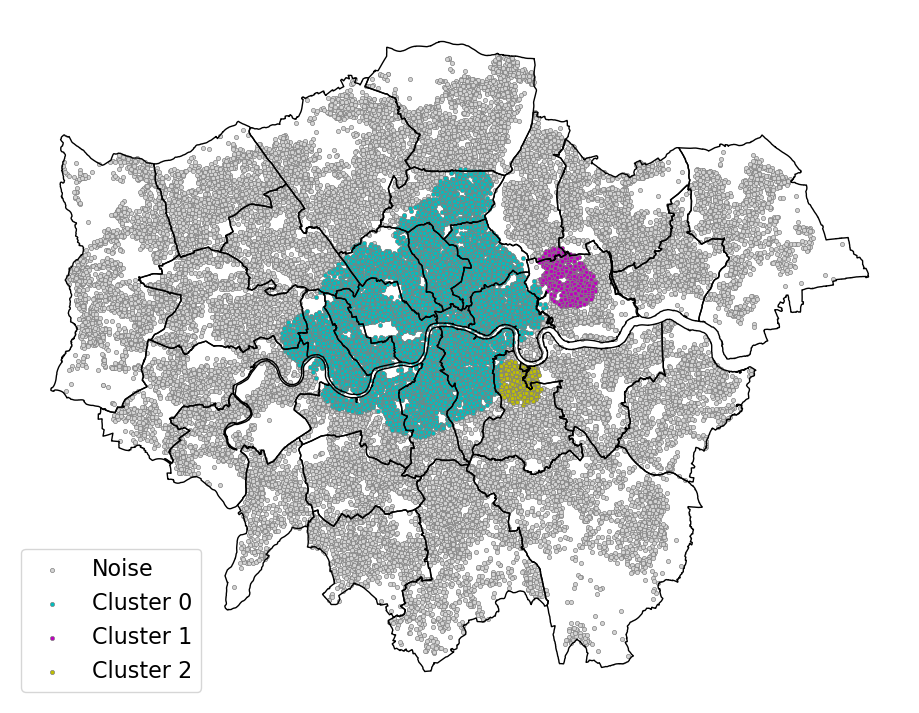

In [110]:
# Setup figure and axis
height = 12
width = height*0.75
fig, ax = plt.subplots(1, figsize=(height, width))

ax.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']))

for lbl in sorted(labels.unique()):

    # if k == -1:
    #     # Plot noise in grey
    #     ax.scatter(db.loc[labels == k, "Longitude"], db.loc[labels == k, "Latitude"], c="grey", s=5, linewidth=0, zorder=1)
    if lbl != -1:
        ax.scatter(db.loc[labels == lbl, "Longitude"], db.loc[labels == lbl, "Latitude"], s=9, linewidth=0.5, ec='gray', zorder=0, label=f"Cluster {lbl}")

    else:
        ## noise
        ax.scatter(db.loc[labels == lbl, "Longitude"], db.loc[labels == lbl, "Latitude"], c="lightgray", s=9, linewidth=0.5, ec='gray', zorder=0, label="Noise")


plt.legend(fontsize=16, )

london_borough.to_crs("EPSG:4326").plot(ax=ax, fc="None", alpha=1, ec="k", linewidth=1)
plt.axis(False)